<a href="https://colab.research.google.com/github/reitezuz/18NES1-2025-/blob/main/week3/tanh_perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceptron with continuous activation function and the gradient descent training algorithm

In [148]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time

class Perceptron:
    def __init__(self, input_dim, activation_function='linear', init_method='zero'):
        # weight initialization:
        if init_method == 'random':
            self.weights = np.random.uniform(-1, 1, (input_dim, 1)) / 10  # Random initialization
            self.bias = float(np.random.uniform(-1, 1) / 10)
        elif init_method == 'widrow-hoff':
            self.weights = np.random.randn(input_dim, 1) * (2 / np.sqrt(input_dim))  # Widrow-Hoff rule
            self.bias = float(np.random.randn() * (2 / np.sqrt(input_dim)))
        else: # init_method == 'zero':
            self.weights = np.zeros((input_dim, 1))  # Initialize weights to zeros
            self.bias = 0.0
        self.activation_function = activation_function
        self.epochs = -1

    def set_weights(self, weights, bias):
        self.weights = np.array(weights, dtype=float).reshape(-1, 1)
        self.bias = float(bias)

    def __str__(self):
        return f"Perceptron(weights={self.weights.T}, bias={self.bias})"

    def activation(self, x):
        if self.activation_function == 'linear':
            return x
        elif self.activation_function == 'tanh':
            return np.tanh(x)
        elif self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        else:
            raise ValueError("Unknown activation function")

    def forward(self, inputs):
        potential = np.dot(inputs, self.weights) + self.bias
        #potential = inputs @ self.weights + self.bias
        return self.activation(potential).flatten()

    def gradient_descent_iterative(self, training_inputs, true_outputs, learning_rate=1, epochs=100, adaptive_learning_rate=True, min_error=0, max_validation_steps=None, validation_set = None,  print_progress=False):
        if print_progress:
            print("Gradient Descent iterative:")
        learning_rate_0 = learning_rate # initial learning rate
        training_errors = []
        validation_errors = []

        if validation_set is not None:
            validation_inputs, validation_true_outputs = validation_set
            validation_steps = 0
            previous_validation_error = MSE_error(validation_true_outputs, self.forward(validation_inputs))

        for epoch in range(epochs):

            # Shuffle the training data for each epoch
            shuffled_indices = np.random.permutation(len(training_inputs))
            training_inputs = training_inputs[shuffled_indices]
            true_outputs = true_outputs[shuffled_indices]

            for inputs, true_output in zip(training_inputs, true_outputs):
                prediction = self.forward(inputs) # (1,)
                error = true_output - prediction.reshape(-1, 1) # (1, 1)

                # derivative of the activation function:
                if self.activation_function == 'linear':
                    grad = error  # (1, 1)
                elif self.activation_function == 'tanh':
                    grad = error * (1 - prediction ** 2)  # (1, 1), tanh derivative
                elif self.activation_function == 'sigmoid':
                    grad = error * prediction * (1 - prediction)  # (1, 1), sigmoid derivative
                else:
                    raise ValueError("Unknown activation function")

                self.weights += learning_rate * grad * inputs.reshape(-1, 1)  # (n, 1)
                self.bias += float((learning_rate * error).item())   # Scalar
            if adaptive_learning_rate:
                learning_rate = learning_rate_0 / ((epoch + 1)**0.5)

            # Validation:
            if validation_set:
                validation_mse = MSE_error(validation_true_outputs, self.forward(validation_inputs))
                validation_errors.append(validation_mse)
                if validation_mse < previous_validation_error:
                    validation_steps = 0
                else:
                    validation_steps += 1
                previous_validation_error = validation_mse

            mse = MSE_error(true_outputs, self.forward(training_inputs))
            training_errors.append(mse)
            if print_progress:
                if validation_set:
                    print(f"Epoch: {epoch}, Training MSE: {mse:0.4f}, Validation MSE: {validation_mse:0.4f} Val steps: {validation_steps} Weights: {self.weights.T} Bias: {self.bias} Learning rate: {learning_rate:.4f}")
                else:
                    print(f"Epoch: {epoch}, MSE: {mse:0.4f} Weights: {self.weights.T} Bias: {self.bias} Learning rate: {learning_rate:.4f}")

            # Stop conditions:
            if (mse <= min_error):
                msg = "Minimum error reached."
                break
            elif (max_validation_steps and validation_steps > max_validation_steps):
                msg = "Maximum validation steps reached."
                break
            else:
                msg = "Maximum epochs reached."
        if print_progress:
            print(f"The training ended after {epoch+1} epochs.", msg)
        self.epochs = epoch+1
        return training_errors, validation_errors


    def gradient_descent_batch(self, training_inputs, true_outputs, learning_rate=1, epochs=100, adaptive_learning_rate=True, min_error=0, max_validation_steps=None, validation_set = None,  print_progress=False):
        if print_progress:
            print("Gradient Descent batch:")

        training_inputs = np.array(training_inputs)  # (m, n)
        true_outputs = np.array(true_outputs).reshape(-1, 1)  # (m, 1)
        batch_size = training_inputs.shape[0]  # Scalar

        learning_rate_0 = learning_rate # initial learning rate
        training_errors = []
        validation_errors = []

        if validation_set is not None:
            validation_inputs, validation_true_outputs = validation_set
            validation_steps = 0
            previous_validation_error = MSE_error(validation_true_outputs, self.forward(validation_inputs))

        for epoch in range(epochs):
            prediction = self.forward(training_inputs).reshape(-1, 1)  # (m, 1)
            error = true_outputs - prediction  # (m, 1)

            if self.activation_function == 'linear':
                grad = error  # (m, 1)
            elif self.activation_function == 'tanh':
                grad = error * (1 - prediction ** 2)  # (m, 1), tanh derivative
            elif self.activation_function == 'sigmoid':
                grad = error * prediction * (1 - prediction)  # (m, 1), sigmoid derivative
            else:
                raise ValueError("Unknown activation function")

            weight_gradient = (training_inputs.T @ grad) / batch_size  # (n, 1)
            bias_gradient = np.mean(grad)  # Scalar

            self.weights += learning_rate * weight_gradient  # (n, 1)
            self.bias += learning_rate * bias_gradient  # Scalar


            if adaptive_learning_rate:
                learning_rate = learning_rate_0 / ((epoch + 1)**0.5)

            # Validation:
            if validation_set:
                validation_mse = MSE_error(validation_true_outputs, self.forward(validation_inputs))
                validation_errors.append(validation_mse)
                if validation_mse < previous_validation_error:
                    validation_steps = 0
                else:
                    validation_steps += 1
                previous_validation_error = validation_mse
            mse = MSE_error(true_outputs.flatten(), self.forward(training_inputs))  # (m,)
            training_errors.append(mse)

            if print_progress:
                if validation_set:
                    print(f"Epoch: {epoch}, Training MSE: {mse:0.4f}, Validation MSE: {validation_mse:0.4f} Weights: {self.weights.T} Bias: {self.bias} Learning rate: {learning_rate:.4f}")
                else:
                    print(f"Epoch: {epoch}, MSE: {mse:0.4f} Weights: {self.weights.T} Bias: {self.bias} Learning rate: {learning_rate:.4f}")

            # Stop conditions:
            if (mse <= min_error):
                msg = "Minimum error reached."
                break
            elif (max_validation_steps and validation_steps > max_validation_steps):
                msg = "Maximum validation steps reached."
                break
            else:
                msg = "Maximum epochs reached."
        if print_progress:
            print(f"The training ended after {epoch+1} epochs.", msg)

        self.epochs = epoch + 1
        return training_errors, validation_errors

def sign(x):
    return np.where(x > 0, 1, np.where(x < 0, -1, 0))

def perceptron_error(true_outputs, predicted_outputs):
    return np.sum(true_outputs != np.round(predicted_outputs))

def SSE_error(true_outputs, predicted_outputs):
    # The Sum squared error
    return np.sum((true_outputs - predicted_outputs) ** 2)
def SAE_error(true_outputs, predicted_outputs):
    # The Sum absolute error
    return np.sum(np.abs(true_outputs - predicted_outputs))
def MAE_error(true_outputs, predicted_outputs):
    # The Mean absolute error
    return np.mean(np.abs(true_outputs - predicted_outputs))
def MSE_error(true_outputs, predicted_outputs):
    # The Mean squared error
    return np.mean((true_outputs - predicted_outputs) ** 2)


### Axiliary functions:


In [149]:

def plot_regression_3D(perceptron, training_inputs, true_outputs):
    """Plots the data points and the regression plane in 3D."""

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot of the data points
    ax.scatter(training_inputs[:, 0], training_inputs[:, 1], true_outputs.flatten(),
               label="Data points", color='blue', alpha=0.4, s=50)

    # Create a meshgrid for the plane
    x_range = np.linspace(min(training_inputs[:, 0]), max(training_inputs[:, 0]), 20)
    y_range = np.linspace(min(training_inputs[:, 1]), max(training_inputs[:, 1]), 20)
    X, Y = np.meshgrid(x_range, y_range)

    # Calculate Z values for the plane using the perceptron's weights and bias
    Z = perceptron.weights[0] * X + perceptron.weights[1] * Y + perceptron.bias

    # Plot the regression plane
    ax.plot_surface(X, Y, Z, alpha=0.5, facecolors=plt.cm.Reds(Z), edgecolor='k', rstride=1, cstride=1)

    # Labels
    ax.set_xlabel("x_1")
    ax.set_ylabel("x_2")
    ax.set_zlabel("y")
    ax.set_title("3D Linear Regression Fit")

    plt.show()
def plot_decision_boundary_3D(perceptron, training_inputs, true_outputs):
    """Plots the decision boundary of the perceptron in 3D."""
    # Select first three columns if more than three exist
    training_inputs = training_inputs[:, :3]

    # Check if the input data has 3 features
    if training_inputs.shape[1] != 3:
        raise ValueError("Input data must have at least 3 features for 3D visualization.")

    # Create a meshgrid of points
    x_min, x_max = training_inputs[:, 0].min() - 1, training_inputs[:, 0].max() + 1
    y_min, y_max = training_inputs[:, 1].min() - 1, training_inputs[:, 1].max() + 1
    z_min, z_max = training_inputs[:, 2].min() - 1, training_inputs[:, 2].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                          np.arange(y_min, y_max, 0.1))

    # Calculate z values for the decision boundary
    zz = (-perceptron.weights[0] * xx - perceptron.weights[1] * yy - perceptron.bias) / perceptron.weights[2]

    # Create the 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the decision boundary
    ax.plot_surface(xx, yy, zz, alpha=0.5)

    # Plot the training data points
    ax.scatter(training_inputs[:, 0], training_inputs[:, 1], training_inputs[:, 2], c=true_outputs, cmap=plt.cm.Paired)

    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('x3')
    ax.set_title('Perceptron Decision Boundary (3D)')

    plt.show()
def plot_decision_boundary_2D(perceptron, training_inputs, true_outputs):
    """Plots the decision boundary of the perceptron."""
    import matplotlib.pyplot as plt
    import numpy as np

    # Extract the first two columns of training_inputs
    x1 = training_inputs[:, 0]
    x2 = training_inputs[:, 1]

    # Generate points for visualization
    x_min, x_max = np.min(x1) - 1, np.max(x1) + 1  # Extend the range slightly
    y_min, y_max = np.min(x2) - 1, np.max(x2) + 1  # Extend the range slightly

    x = np.linspace(x_min, x_max, 100)
    weights = perceptron.weights.flatten()
    y = -(weights[0] * x + perceptron.bias) / weights[1]

    plt.figure(figsize=(5, 3))
    # Plot the decision boundary
    plt.plot(x, y, label='Decision Boundary')

    # Plot the points
    for i, input_vector in enumerate(training_inputs):
        if true_outputs[i] == 1:
            plt.scatter(input_vector[0], input_vector[1], color='green', label='Class 1' if i == 0 else "")  # Add label only for the first point of each class
        else:
            plt.scatter(input_vector[0], input_vector[1], color='red', label='Class -1' if i == 0 else "")

    plt.xlabel('x1', fontsize=12)
    plt.ylabel('x2', fontsize=12)
    plt.title('Perceptron Decision Boundary', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)  # Set y-axis limits

    # Highlight x and y axes
    plt.axhline(0, color='black', linewidth=0.8)  # x-axis
    plt.axvline(0, color='black', linewidth=0.8)  # y-axis
    plt.show()

def plot_regression(perceptron, training_inputs, true_outputs):
    """Plots the data points and the regression line."""
    plt.figure(figsize=(4, 3))

    # Plot the data points
    plt.scatter(training_inputs, true_outputs, label="Data points", color='blue', alpha=0.6)

    # Generate predictions for the regression line
    X_test = np.linspace(-1, 1, 100).reshape(-1, 1)
    d_pred = perceptron.weights * X_test + perceptron.bias

    plt.plot(X_test, d_pred, label="Regression line", color='red', linewidth=2)
    plt.xlabel("x_1")
    plt.ylabel("y")
    plt.legend()
    plt.title("Linear Regression Fit")
    plt.show()

def plot_error_progress(train_errors, validation_errors):
    fig = plt.figure(figsize=(4, 3))
    if validation_errors:
        plt.plot(validation_errors, label='Validation Error')
    plt.plot(train_errors, label='Train Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.title('Validation and Train Error Progress')
    plt.legend()
    plt.grid(True)
    plt.show()


### Run tests

In [150]:

def run_example_multiple_times(experiment_results, training_data, testing_data, validation_data, activation, epochs, init_method, learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=10, num_runs=10):
    inputs, true_outputs = training_data
    if testing_data is None:
        testing_data = training_data
    max_validation_steps = None if validation_data is None else max_validation_steps
    test_inputs, test_true_outputs = testing_data
    times = []
    mse_errors = []
    mae_errors = []
    mse_test_errors = []
    mae_test_errors = []
    epoch_counts = []

    for _ in range(num_runs):

        start_time = time.time()
        neuron = Perceptron(inputs.shape[1], activation, init_method)

        if variant == 'iterative':
            neuron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress)
        else:
            neuron.gradient_descent_batch(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress, print_progress=print_progress)

        end_time = time.time()
        elapsed_time = end_time - start_time

        real_outputs = neuron.forward(inputs)
        mse = MSE_error(true_outputs, real_outputs)
        mae = MAE_error(true_outputs, real_outputs)

        real_outputs = neuron.forward(test_inputs)
        mse_test = MSE_error(test_true_outputs, real_outputs)
        mae_test = MAE_error(test_true_outputs, real_outputs)

        times.append(elapsed_time)
        mse_errors.append(mse)
        mae_errors.append(mae)
        mse_test_errors.append(mse_test)
        mae_test_errors.append(mae_test)
        epoch_counts.append(neuron.epochs)

    avg_time = np.mean(times)
    avg_mse = np.mean(mse_errors)
    avg_mae = np.mean(mae_errors)
    avg_test_mse = np.mean(mse_test_errors)
    avg_test_mae = np.mean(mae_test_errors)
    avg_epochs = np.mean(epoch_counts)

    results = {
        'Epochs': avg_epochs,
        'MSE': avg_mse,
        'MAE': avg_mae,
        'Test MSE': avg_test_mse,
        'Test MAE': avg_test_mae,
        'Time': avg_time,
        'Variant': variant,
        'Learning Rate': learning_rate,
        'Max Epochs': epochs,
        'Weights': neuron.weights,  # Note: Weights and bias are from the last run.
        'Bias': neuron.bias,
        'Data Description': data_description
    } #experiment_results_r = pd.DataFrame(columns=['MSE', 'SSE', 'Test MSE' 'Test MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])

    experiment_results.loc[len(experiment_results)] = results

## Example 1:  Gallbladder Attack
- We predict whether a patient will have a gallbladder attack, depending on whether they ate a salad, pork belly, and whether they took medication.

In [151]:
def example_gallblader_attack():
    # Egg Salad, Pork Belly, Medicines -> Gallbladder Attack
    inputs = np.array([
        [+1, -1, -1],
        [+1, -1, +1],
        [-1, +1, -1],
        [-1, +1, +1],
        [+1, +1, -1],
        [+1, +1, +1]
    ])

    true_outputs = np.array([
        +1,
        -1,
        +1,
        -1,
        +1,
        +1
    ])
    return inputs, true_outputs

- Set the parameters, run the experiment and observe the results:
- Compare the results with the Rosenblatt training algorithm (perceptron_examples.ipynb)
- Experiment with the learning rate and other training parameters (maximum number of epochs, adaptive learning rate) and observe, how it affects the training process and the outputs

Gradient Descent iterative:
Epoch: 0, MSE: 0.5714 Weights: [[ 1.02317807 -0.14194036 -1.06332446]] Bias: 0.21749675438943789 Learning rate: 0.5000
Epoch: 1, MSE: 0.2083 Weights: [[ 0.87769908  0.95347668 -2.00167596]] Bias: 0.05437724107712982 Learning rate: 0.5000
Epoch: 2, MSE: 0.0083 Weights: [[ 1.48394745  1.44792294 -1.61663581]] Bias: 0.33824160296333666 Learning rate: 0.5000
Epoch: 3, MSE: 0.0068 Weights: [[ 1.48363999  1.46519889 -1.64792111]] Bias: 0.2932510201690155 Learning rate: 0.5000
Epoch: 4, MSE: 0.0059 Weights: [[ 1.48928342  1.47456322 -1.67551648]] Bias: 0.24990187890272353 Learning rate: 0.5000
Epoch: 5, MSE: 0.0055 Weights: [[ 1.49978149  1.48423793 -1.69081265]] Bias: 0.24462632596265843 Learning rate: 0.5000
Epoch: 6, MSE: 0.0051 Weights: [[ 1.5079031   1.49100038 -1.71247077]] Bias: 0.2078140814846382 Learning rate: 0.5000
Epoch: 7, MSE: 0.0048 Weights: [[ 1.5156192   1.50079135 -1.72815392]] Bias: 0.1909678512194089 Learning rate: 0.5000
Epoch: 8, MSE: 0.0047 W

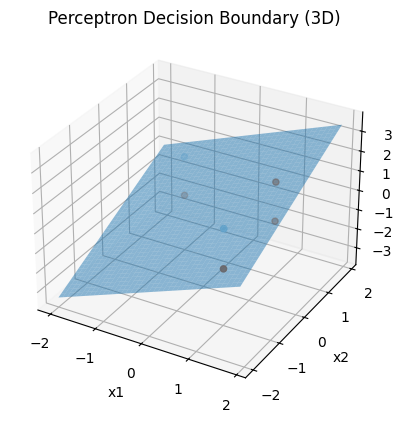

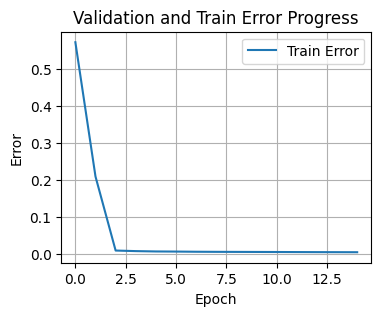

,Input,Predicted,True
0,"[1, -1, -1]",[0.9643561661012994],1
1,"[1, -1, 1]",[-0.9180249200221461],-1
2,"[-1, 1, -1]",[0.9630140216358128],1
3,"[-1, 1, 1]",[-0.9209338695243486],-1
4,"[1, 1, -1]",[0.999931658413698],1
5,"[1, 1, 1]",[0.9155924608747662],1


In [152]:
# Data and parameters:
inputs, true_outputs = example_gallblader_attack()
data_description = "Gallbladder Attack"

print_progress = True
activation = 'tanh'
learning_rate = 0.5
init_method = 'random'
adaptive_learning_rate = False
min_error = 0.0001
epochs = 15

# Train the linear neuron:
perceptron = Perceptron(inputs.shape[1], activation, init_method)
# perceptron.set_weights(np.array([10000, 10000]), 10000) # set weights to large values
train_errors, val_errors =  perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress=print_progress)
# Print summary:
print(perceptron)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
error = perceptron_error(true_outputs, real_outputs)
print(f"Perceptron error: {error}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
plot_decision_boundary_3D(perceptron, inputs, true_outputs)
plot_error_progress(train_errors, val_errors)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df


- finetune parameters of the algorithm:
    1. number of epochs
    2. learning rate
    3. adaptive learning rate or not?

In [153]:
# DataFrame to store the results for comparisons:
experiment_results_r = pd.DataFrame(columns=['MSE', 'MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])

inputs, true_outputs = example_gallblader_attack()
data_description_orig = "Gallbladder Attack"

# Perceptron parameters:
variant = "iterative"
activation = 'tanh'
adaptive_learning_rate = False
min_error = 0.0001
epochs = 100
learning_rate = 0.1
init_method = 'random'
print_progress = False

data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error)

# learning rate:
for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, activation, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)

# epochs:
learning_rate = 0.1
for epochs in [2, 5, 10, 20]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, activation, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)

# adaptive learning rate:
adaptive_learning_rate = True
data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error)
epochs = 100
for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, activation, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)

print("\nExperiment Results:")
experiment_results_r


Experiment Results:


,MSE,MAE,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,0.098489,0.269804,100.0,0.011760,iterative,0.01,100,"[[0.6522217929519841], [0.6520845711609146], [...",0.248576,Gallbladder Attack non-adaptive 0.0001
1,0.007074,0.072183,100.0,0.011516,iterative,0.10,100,"[[1.403016300508691], [1.404511873746145], [-1...",0.210829,Gallbladder Attack non-adaptive 0.0001
2,0.000175,0.009181,65.9,0.007962,iterative,1.00,100,"[[2.651539416698433], [2.502419736989106], [-5...",3.382151,Gallbladder Attack non-adaptive 0.0001
3,0.312574,0.509458,2.0,0.000268,iterative,0.10,2,"[[0.27092033134680826], [0.293350537396575], [...",0.271772,Gallbladder Attack non-adaptive 0.0001
4,0.162102,0.350860,5.0,0.000634,iterative,0.10,5,"[[0.47881237078687583], [0.4808242024784466], ...",0.195524,Gallbladder Attack non-adaptive 0.0001
5,0.081235,0.245490,10.0,0.001260,iterative,0.10,10,"[[0.7027021241571153], [0.7130468166521037], [...",0.242235,Gallbladder Attack non-adaptive 0.0001
6,0.039090,0.169563,20.0,0.002251,iterative,0.10,20,"[[0.9272818322574162], [0.9262996252268434], [...",0.236293,Gallbladder Attack non-adaptive 0.0001
7,0.364645,0.561537,100.0,0.010742,iterative,0.01,100,"[[0.27123231727525154], [0.2548322285631811], ...",0.164445,Gallbladder Attack adaptive 0.0001
8,0.045197,0.181655,100.0,0.010510,iterative,0.10,100,"[[0.8900252446024901], [0.8899703574912754], [...",0.233761,Gallbladder Attack adaptive 0.0001
9,0.001211,0.023879,90.3,0.011087,iterative,1.00,100,"[[2.7399646826853177], [2.955535038075003], [-...",0.437269,Gallbladder Attack adaptive 0.0001


## Example 2:  Pub
- We predict whether the friends (Pavel, Pepa, Honza) will go to a pub depending on who of them has currently time.

In [154]:
def example_pub():
    # Pavel, Pepa, Honza -> Go to a pub?
    inputs = np.array([
        [ +1, -1, -1],
        [ +1, -1, +1],
        [ -1, +1, -1],
        [ -1, +1, +1],
        [ +1, +1, -1],
        [ +1, +1, +1],
        [ -1, -1, -1],
        [ -1, -1, +1]
    ])

    true_outputs = np.array([-1, +1, -1, +1, +1, +1, -1, -1])
    return inputs, true_outputs

- Set the parameters, run the experiment and observe the results:
- Compare the results with the Rosenblatt training algorithm (perceptron_examples.ipynb)
- Experiment with the learning rate and other training parameters (maximum number of epochs, adaptive learning rate) and observe, how it affects the training process and the outputs

Gradient Descent iterative:
Epoch: 0, MSE: 0.2748 Weights: [[0.39293333 1.22336207 0.84649677]] Bias: 0.029615694883545263 Learning rate: 0.5000
Epoch: 1, MSE: 0.1500 Weights: [[1.17702079 0.81309895 1.29035314]] Bias: 0.547373353851274 Learning rate: 0.5000
Epoch: 2, MSE: 0.0102 Weights: [[1.452578   1.45540069 1.34825154]] Bias: -0.0804599900222363 Learning rate: 0.5000
Epoch: 3, MSE: 0.0089 Weights: [[1.47484766 1.46535793 1.39978794]] Bias: -0.08220962098382012 Learning rate: 0.5000
Epoch: 4, MSE: 0.0076 Weights: [[1.48560951 1.4900915  1.4401839 ]] Bias: -0.02391053477783245 Learning rate: 0.5000
Epoch: 5, MSE: 0.0070 Weights: [[1.50042468 1.50701297 1.47377474]] Bias: -0.0011896526603244473 Learning rate: 0.5000
Epoch: 6, MSE: 0.0065 Weights: [[1.52050117 1.52048668 1.4993052 ]] Bias: 0.033550420706041695 Learning rate: 0.5000
Epoch: 7, MSE: 0.0060 Weights: [[1.53671541 1.53469679 1.52382475]] Bias: 0.025881614454521695 Learning rate: 0.5000
Epoch: 8, MSE: 0.0056 Weights: [[1.555

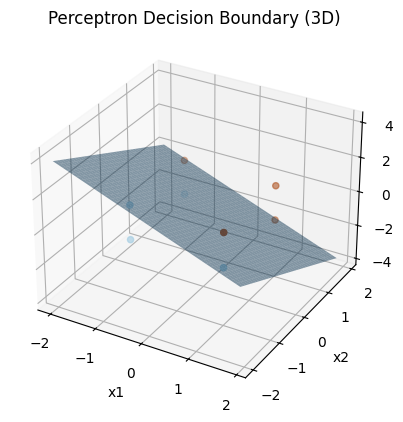

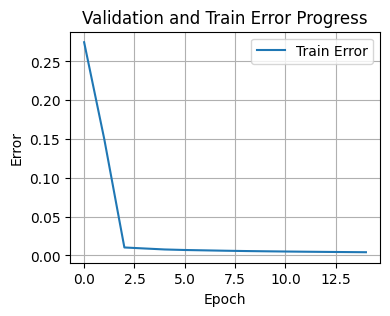

,Input,Predicted,True
0,"[1, -1, -1]",[-0.9259375316611842],-1
1,"[1, -1, 1]",[0.9257209644969661],1
2,"[-1, 1, -1]",[-0.9260777354043827],-1
3,"[-1, 1, 1]",[0.9255801102336867],1
4,"[1, 1, -1]",[0.9268312695067783],1
5,"[1, 1, 1]",[0.9998873538763653],1
6,"[-1, -1, -1]",[-0.999887915662833],-1
7,"[-1, -1, 1]",[-0.9271829091425394],-1


In [155]:
# Data and parameters:
inputs, true_outputs = example_pub()
data_description = "Pub"

print_progress = True
activation = 'tanh'
learning_rate = 0.5
init_method = 'random'
adaptive_learning_rate = False
min_error = 0.0001
epochs = 15

# Train the linear neuron:
perceptron = Perceptron(inputs.shape[1], activation, init_method)
# perceptron.set_weights(np.array([10000, 10000]), 10000) # set weights to large values
train_errors, val_errors = perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress=print_progress)
# Print summary:
print(perceptron)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
error = perceptron_error(true_outputs, real_outputs)
print(f"Perceptron error: {error}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
plot_decision_boundary_3D(perceptron, inputs, true_outputs)
plot_error_progress(train_errors, val_errors)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df


- finetune parameters of the algorithm:
    1. number of epochs
    2. learning rate
    3. adaptive learning rate or not?

In [156]:
# DataFrame to store the results for comparisons:
experiment_results_r = pd.DataFrame(columns=['MSE', 'MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])

inputs, true_outputs = example_gallblader_attack()
data_description_orig = "Gallbladder Attack"

# Perceptron parameters:
variant = "iterative"
activation = 'tanh'
adaptive_learning_rate = False
min_error = 0.0001
epochs = 100
learning_rate = 0.1
init_method = 'random'
print_progress = False

data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error)

# learning rate:
for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, activation, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)

# epochs:
learning_rate = 0.1
for epochs in [2, 5, 10, 20]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, activation, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)

# adaptive learning rate:
adaptive_learning_rate = True
data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error)
epochs = 100
for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, activation, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)

print("\nExperiment Results:")
experiment_results_r


Experiment Results:


,MSE,MAE,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,0.099174,0.270612,100.0,0.010826,iterative,0.01,100,"[[0.6405217983467152], [0.6401091349404092], [...",0.251464,Gallbladder Attack non-adaptive 0.0001
1,0.007069,0.072166,100.0,0.011550,iterative,0.10,100,"[[1.4038918635203665], [1.404725209679079], [-...",0.210112,Gallbladder Attack non-adaptive 0.0001
2,0.000155,0.008243,74.8,0.009156,iterative,1.00,100,"[[2.161119408161914], [2.166305540067328], [-2...",0.254604,Gallbladder Attack non-adaptive 0.0001
3,0.323977,0.520741,2.0,0.000250,iterative,0.10,2,"[[0.28769699487192535], [0.2770305678499848], ...",0.260003,Gallbladder Attack non-adaptive 0.0001
4,0.155088,0.343211,5.0,0.000589,iterative,0.10,5,"[[0.4839604615612043], [0.49313278611634653], ...",0.211351,Gallbladder Attack non-adaptive 0.0001
5,0.080813,0.244475,10.0,0.001139,iterative,0.10,10,"[[0.713043812326359], [0.6993319257750651], [-...",0.258706,Gallbladder Attack non-adaptive 0.0001
6,0.038769,0.168926,20.0,0.002843,iterative,0.10,20,"[[0.9374947721441894], [0.9422236572272272], [...",0.221951,Gallbladder Attack non-adaptive 0.0001
7,0.362366,0.560959,100.0,0.019093,iterative,0.01,100,"[[0.2179976368620979], [0.2115145016614805], [...",0.191353,Gallbladder Attack adaptive 0.0001
8,0.045330,0.181923,100.0,0.011115,iterative,0.10,100,"[[0.8853066629612737], [0.8857237314291234], [...",0.238653,Gallbladder Attack adaptive 0.0001
9,0.001185,0.023598,90.3,0.009702,iterative,1.00,100,"[[1.9759831978572082], [1.8966315402042557], [...",0.255228,Gallbladder Attack adaptive 0.0001


## Example 3 - Linear regression with two input dimensions
- we normalize the outputs, so that the values are in range [-1, 1]


In [157]:
def generate_regression_data_2D(A=2, B=3, C=-4, std_noise=0.3, number_of_samples=100):
    # y = A x1 + B x2 + C + noise

    # Generate x1 and x2 from a uniform distribution (more variation than linspace)
    x1 = np.random.uniform(-1, 1, number_of_samples).reshape(-1, 1)
    x2 = np.random.uniform(-1, 1, number_of_samples).reshape(-1, 1)
    x2 = x2[np.random.permutation(number_of_samples)]  # Randomly shuffle x2
    inputs = np.hstack([x1, x2])

    # Define true function with noise
    noise = np.random.normal(0, std_noise, size=x1.shape)  # Gaussian noise
    true_outputs = A*x1 + B*x2 + C + noise
    return inputs, normalize_outputs(true_outputs)


def normalize_outputs(outputs):
    min_val = np.min(outputs)
    max_val = np.max(outputs)

    # Normalize to the range [0, 1]
    normalized_outputs = (outputs - min_val) / (max_val - min_val)

    # Scale to the range [-1, 1]
    normalized_outputs = 2 * normalized_outputs - 1

    return normalized_outputs


- observe, that the regression task is very difficult for a perceptron with tanh activation function and that it is very sensitive to the choice of initial learning rate:

Gradient Descent iterative:
Epoch: 0, Training MSE: 0.2068, Validation MSE: 0.1644 Val steps: 0 Weights: [[ 0.00738077 -0.0655308 ]] Bias: 0.08654117121454812 Learning rate: 0.0002
Epoch: 1, Training MSE: 0.2055, Validation MSE: 0.1634 Val steps: 0 Weights: [[ 0.00945077 -0.06146708]] Bias: 0.08284362110236623 Learning rate: 0.0002
Epoch: 2, Training MSE: 0.2042, Validation MSE: 0.1625 Val steps: 0 Weights: [[ 0.01151331 -0.05742082]] Bias: 0.07920611570497738 Learning rate: 0.0002
Epoch: 3, Training MSE: 0.2030, Validation MSE: 0.1616 Val steps: 0 Weights: [[ 0.01356847 -0.05339531]] Bias: 0.07562323496848676 Learning rate: 0.0002
Epoch: 4, Training MSE: 0.2019, Validation MSE: 0.1608 Val steps: 0 Weights: [[ 0.01561694 -0.04938811]] Bias: 0.07210018813498155 Learning rate: 0.0002
Epoch: 5, Training MSE: 0.2008, Validation MSE: 0.1600 Val steps: 0 Weights: [[ 0.01766042 -0.04539792]] Bias: 0.06864019650832691 Learning rate: 0.0002
Epoch: 6, Training MSE: 0.1997, Validation MSE: 0.1593

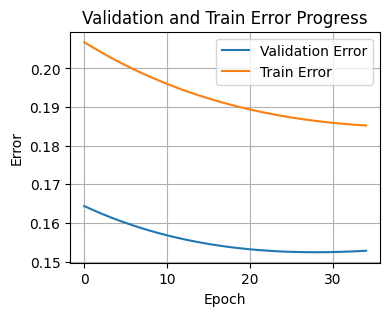

Train Perceptron error: 10000, Test PE: 10000
Train MAE error: 0.35620109659375765, Test MAE: 0.3927520902897308
Train MSE error: 0.18521468020434576, Test MSE: 0.23298108244580498


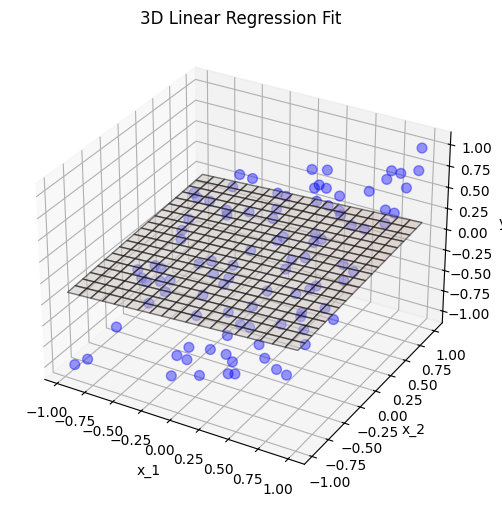

,Input,Predicted,True
0,"[-0.8448539895026337, 0.712660291099813]",[-0.029154781726043386],[-0.08482939566584691]
1,"[-0.8478934011580141, -0.1300324713689427]",[-0.08075750214765536],[-0.5053663332610245]
2,"[0.6787499276550828, -0.12308390629741983]",[0.031192988689632082],[0.007056570795338946]
3,"[-0.15129478301059907, -0.7557046678038366]",[-0.06812754398067858],[-0.7069434613550143]
4,"[0.45617185416805706, -0.584530723137457]",[-0.013310337480484592],[-0.44381523812341095]
...,...,...,...
95,"[0.9368979121916077, 0.8143458579928002]",[0.10702502053250533],[0.6289637274722157]
96,"[0.30848801467079845, -0.20458974890446013]",[-0.0008765162727058058],[-0.14352376146270318]
97,"[0.3409981955802106, 0.6857392843443708]",[0.05590630771299752],[0.2818254652111525]
98,"[-0.6336265696503174, 0.9057688313708456]",[-0.0018938922053871753],[0.006558043063151331]


In [158]:
# Define parameters
inputs, true_outputs = generate_regression_data_2D(A=2, B=3, C=-4, std_noise=0.5, number_of_samples=100)
test_inputs, test_true_outputs = generate_regression_data_2D(A=2, B=3, C=-4, std_noise=0.5, number_of_samples=100)
validation_data = generate_regression_data_2D(A=2, B=3, C=-4, std_noise=0.5, number_of_samples=100)

# Train the perceptron:
activation = 'tanh'
print_progress = True
learning_rate = 0.0002
init_method = 'random'
adaptive_learning_rate = False#True #False
min_error = 0.00001
epochs = 100
variant = "iterative" #"batch" #"iterative"
max_validation_steps = 5 #  early stopping

# Train the linear neuron:
perceptron = Perceptron(inputs.shape[1], activation, init_method)
if variant == 'iterative':
    [training_errors, validation_errors] = perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)
else:
    [training_errors, validation_errors] = perceptron.gradient_descent_batch(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)

# Print summary:
print(perceptron)
plot_error_progress(training_errors, validation_errors)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
test_outputs = perceptron.forward(test_inputs)
print(f"Train Perceptron error: {perceptron_error(true_outputs, real_outputs)}, Test PE: {perceptron_error(test_true_outputs, test_outputs)}")
print(f"Train MAE error: {MAE_error(true_outputs, real_outputs)}, Test MAE: {MAE_error(test_true_outputs, test_outputs)}")
print(f"Train MSE error: {MSE_error(true_outputs, real_outputs)}, Test MSE: {MSE_error(test_true_outputs, test_outputs)}")
plot_regression_3D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df

## Example 4:  Randomly Generated Clustered Data


In [159]:
def example_random_clusters(N = 40, spread = 2.0):
    """ Generate two separable clusters """
    cluster_1 = np.random.randn(N//2, 2) * spread + np.array([2, 2])
    cluster_2 = np.random.randn(N//2, 2) * spread + np.array([-2, -2])
    inputs = np.vstack((cluster_1, cluster_2))
    true_outputs = np.hstack((np.ones(N//2), -np.ones(N//2)))  # Labels for clusters
    return inputs, true_outputs.flatten()

- Set the parameters, run the experiment and observe the results:
- Compare the results with the Rosenblatt training algorithm (perceptron_examples.ipynb)
- Experiment with the learning rate and other training parameters (maximum number of epochs, adaptive learning rate) and observe, how it affects the training process and the outputs
- Experiment with biased weights and observe how they affect training

Gradient Descent iterative:
Epoch: 0, Training MSE: 0.8352, Validation MSE: 0.8555 Val steps: 0 Weights: [[ 0.06266852 -0.01446535]] Bias: -0.09082525273095399 Learning rate: 0.0010
Epoch: 1, Training MSE: 0.6022, Validation MSE: 0.5999 Val steps: 0 Weights: [[0.11110168 0.03225752]] Bias: -0.08624653093343629 Learning rate: 0.0007
Epoch: 2, Training MSE: 0.5198, Validation MSE: 0.5126 Val steps: 0 Weights: [[0.1359641  0.05510876]] Bias: -0.08273859704809591 Learning rate: 0.0006
Epoch: 3, Training MSE: 0.4746, Validation MSE: 0.4668 Val steps: 0 Weights: [[0.15309984 0.07000154]] Bias: -0.08006137025884952 Learning rate: 0.0005
Epoch: 4, Training MSE: 0.4452, Validation MSE: 0.4383 Val steps: 0 Weights: [[0.16597094 0.08104429]] Bias: -0.07775040539818953 Learning rate: 0.0004
Epoch: 5, Training MSE: 0.4239, Validation MSE: 0.4184 Val steps: 0 Weights: [[0.17650538 0.08977977]] Bias: -0.0757495809341239 Learning rate: 0.0004
Epoch: 6, Training MSE: 0.4075, Validation MSE: 0.4037 Val 

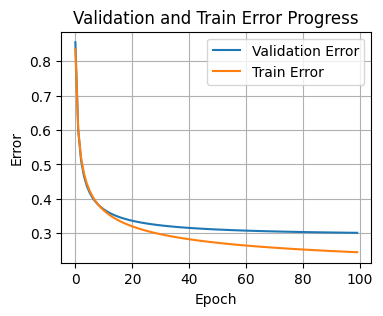

Train Perceptron error: 13, Test PE: 9
Train MAE error: 0.36764289840123054, Test MAE: 0.32364204335633284
Train MSE error: 0.24493296409583767, Test MSE: 0.23362338626494666


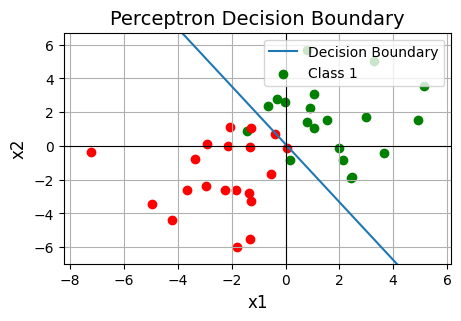

,Input,Predicted,True
0,"[2.9934283060224653, 1.7234713976576308]",[0.8839695837400349],1.0
1,"[3.295377076201385, 5.046059712816051]",[0.9750929226777484],1.0
2,"[1.531693250553328, 1.5317260861016389]",[0.6840810153057033],1.0
3,"[5.158425631014783, 3.534869458305818]",[0.987485690872895],1.0
4,"[1.0610512281300957, 3.085120087171929]",[0.7577712481477545],1.0
5,"[1.0731646143750755, 1.0685404928594862]",[0.5218118106458111],1.0
6,"[2.4839245431320682, -1.8265604893155958]",[0.44644779682087915],1.0
7,"[-1.4498356650260655, 0.8754249415180546]",[-0.3398574806430954],1.0
8,"[-0.02566224066884759, 2.628494665190548]",[0.47156721130591217],1.0
9,"[0.1839518489575782, -0.824607402670583]",[-0.1261192832107023],1.0


In [160]:
# Data and parameters:
np.random.seed(42)
inputs, true_outputs = example_random_clusters()
test_inputs, test_true_outputs = example_random_clusters()
validation_data = example_random_clusters()
data_description = "Clusters"

activation = 'tanh'
print_progress = True
learning_rate = 0.001
init_method = 'random'
adaptive_learning_rate = True #False
min_error = 0.0001
epochs = 100
variant = "iterative" #"batch" #"iterative"
max_validation_steps = 5 #  early stopping

# Train the neuron:
perceptron = Perceptron(inputs.shape[1], activation, init_method)
# perceptron.set_weights(np.array([10000, 10000]), 10000) # set weights to large values
if variant == 'iterative':
    [training_errors, validation_errors] = perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)
else:
    [training_errors, validation_errors] = perceptron.gradient_descent_batch(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)


# Print summary:
print(perceptron)
plot_error_progress(training_errors, validation_errors)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
test_outputs = perceptron.forward(test_inputs)
print(f"Train Perceptron error: {perceptron_error(true_outputs, real_outputs)}, Test PE: {perceptron_error(test_true_outputs, test_outputs)}")
print(f"Train MAE error: {MAE_error(true_outputs, real_outputs)}, Test MAE: {MAE_error(test_true_outputs, test_outputs)}")
print(f"Train MSE error: {MSE_error(true_outputs, real_outputs)}, Test MSE: {MSE_error(test_true_outputs, test_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df


- observe overfitting for small datsets and try to apply early stopping:
- try both the iterative and batch variant:

Gradient Descent iterative:
Epoch: 0, Training MSE: 0.4830, Validation MSE: 0.7134 Val steps: 1 Weights: [[0.20003342 0.16680533]] Bias: -0.07319801154849757 Learning rate: 0.0100
Epoch: 1, Training MSE: 0.4741, Validation MSE: 0.7471 Val steps: 2 Weights: [[0.23669615 0.19873049]] Bias: -0.08069418235580743 Learning rate: 0.0071
Epoch: 2, Training MSE: 0.4672, Validation MSE: 0.7279 Val steps: 0 Weights: [[0.23679148 0.22048655]] Bias: -0.09259656801524796 Learning rate: 0.0058
Epoch: 3, Training MSE: 0.4643, Validation MSE: 0.7251 Val steps: 0 Weights: [[0.24033987 0.23204336]] Bias: -0.09993375221602238 Learning rate: 0.0050
Epoch: 4, Training MSE: 0.4617, Validation MSE: 0.7125 Val steps: 0 Weights: [[0.23874332 0.24353809]] Bias: -0.10657430241610247 Learning rate: 0.0045
Epoch: 5, Training MSE: 0.4603, Validation MSE: 0.7086 Val steps: 0 Weights: [[0.23986482 0.2511482 ]] Bias: -0.11141195284337559 Learning rate: 0.0041
Epoch: 6, Training MSE: 0.4591, Validation MSE: 0.6985 Val s

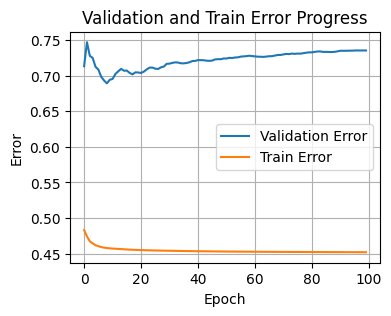

Train Perceptron error: 11, Test PE: 4
Train MAE error: 0.4398020854517034, Test MAE: 0.4021661690941212
Train MSE error: 0.45186271876087036, Test MSE: 0.31606440755828025


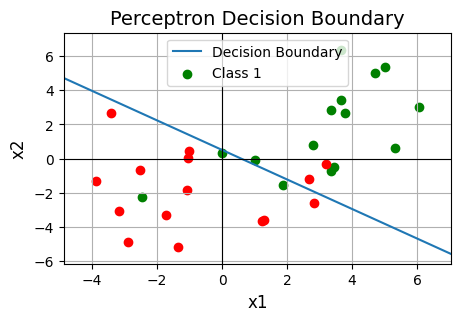

In [161]:
# Data and parameters:
np.random.seed(114570)
inputs, true_outputs = example_random_clusters(N=30, spread=3)
test_inputs, test_true_outputs = example_random_clusters(N=10, spread=3)
validation_data = example_random_clusters(N=10, spread=3)
data_description = "Clusters"

activation = 'tanh'
print_progress = True
learning_rate = 0.01
init_method = 'random'
adaptive_learning_rate = True #False
min_error = 0.0001
epochs = 100
variant = "iterative" #"batch" #"batch" #"iterative"
max_validation_steps = None # 5 #  early stopping

# Train the neuron:
perceptron = Perceptron(inputs.shape[1], activation, init_method)
if variant == 'iterative':
    [training_errors, validation_errors] = perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)
else:
    [training_errors, validation_errors] = perceptron.gradient_descent_batch(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)


# Print summary:
print(perceptron)
plot_error_progress(training_errors, validation_errors)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
test_outputs = perceptron.forward(test_inputs)
print(f"Train Perceptron error: {perceptron_error(true_outputs, real_outputs)}, Test PE: {perceptron_error(test_true_outputs, test_outputs)}")
print(f"Train MAE error: {MAE_error(true_outputs, real_outputs)}, Test MAE: {MAE_error(test_true_outputs, test_outputs)}")
print(f"Train MSE error: {MSE_error(true_outputs, real_outputs)}, Test MSE: {MSE_error(test_true_outputs, test_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
#df

- finetune parameters of the algorithm:
    1. number of epochs
    2. learning rate
    3. adaptive learning rate or not?

In [162]:
# DataFrame to store the results for comparisons:
#experiment_results_r = pd.DataFrame(columns=['MSE', 'MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
experiment_results_r = pd.DataFrame(columns=['MSE', 'MAE', 'Test MSE', 'Test MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])

np.random.seed(42) # For reproducibility
inputs, true_outputs = example_random_clusters()
test_inputs, test_true_outputs = example_random_clusters()
validation_data = example_random_clusters()
data_description = "Clusters"

activation = 'tanh'
print_progress = False
learning_rate = 0.001
init_method = 'random'
adaptive_learning_rate = True #False
min_error = 0.0001
epochs = 100
variant = "iterative" #"batch" #"iterative"
max_validation_steps = None #5 #  early stopping



data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error)

# learning rate:
for learning_rate in [0.0001, 0.001 , 0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, activation, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)

# epochs:
learning_rate = 0.1
for epochs in [2, 5, 10, 20]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, activation, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)

# adaptive learning rate:
adaptive_learning_rate = True
data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error)
epochs = 100
for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, activation, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)


print("\nExperiment Results:")
experiment_results_r


Experiment Results:


,MSE,MAE,Test MSE,Test MAE,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,0.542256,0.700018,0.542256,0.700018,100.0,0.057196,iterative,0.0001,100,"[[0.08227811557859421], [0.10891266548737528]]",0.021600,Gallbladder Attack adaptive 0.0001
1,0.240563,0.364288,0.240563,0.364288,100.0,0.054181,iterative,0.0010,100,"[[0.34651176420592383], [0.20780407562784575]]",0.086882,Gallbladder Attack adaptive 0.0001
2,0.179286,0.221472,0.179286,0.221472,100.0,0.054806,iterative,0.0100,100,"[[0.6890299043046907], [0.3639985092871345]]",0.153723,Gallbladder Attack adaptive 0.0001
3,0.178509,0.192822,0.178509,0.192822,100.0,0.054526,iterative,0.1000,100,"[[0.8714622131936135], [0.42212131445844864]]",0.217063,Gallbladder Attack adaptive 0.0001
4,0.205149,0.130609,0.205149,0.130609,100.0,0.057029,iterative,1.0000,100,"[[6.954932723778308], [1.8073077274339981]]",1.079656,Gallbladder Attack adaptive 0.0001
5,0.178401,0.198333,0.178401,0.198333,2.0,0.002274,iterative,0.1000,2,"[[0.8339608912409646], [0.39526536211189556]]",0.173272,Gallbladder Attack adaptive 0.0001
6,0.178040,0.194856,0.178040,0.194856,5.0,0.005152,iterative,0.1000,5,"[[0.8330230581205676], [0.38262367111692436]]",0.170442,Gallbladder Attack adaptive 0.0001
7,0.178290,0.192492,0.178290,0.192492,10.0,0.010378,iterative,0.1000,10,"[[0.8818121377231698], [0.4300494775773935]]",0.246607,Gallbladder Attack adaptive 0.0001
8,0.178704,0.191157,0.178704,0.191157,20.0,0.019366,iterative,0.1000,20,"[[0.8726955568635928], [0.41943270734551263]]",0.213031,Gallbladder Attack adaptive 0.0001
9,0.179365,0.221468,0.179365,0.221468,100.0,0.095747,iterative,0.0100,100,"[[0.6898650779498583], [0.36325767666902226]]",0.158046,Gallbladder Attack adaptive 0.0001


## Example 4a:  Randomly Generated Clustered Data And Normalization


- the input data are shifted:

In [163]:
def example_shifted_clusters():
    """ Generate two separable clusters """
    N=40
    spread=2.0
    cluster_1 = np.random.randn(N//2, 2) * spread + np.array([2, 2])+500
    cluster_2 = np.random.randn(N//2, 2) * spread + np.array([-2, -2])+500
    inputs = np.vstack((cluster_1, cluster_2))
    true_outputs = np.hstack((np.ones(N//2), -np.ones(N//2)))  # Labels for clusters
    return inputs, true_outputs

def normalize_data(data):
    """Normalizes data to the range [-1, 1]."""
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)

    # Avoid division by zero if min and max are the same
    max_vals = np.where(max_vals == min_vals, max_vals + 1e-6, max_vals)

    normalized_data = 2 * (data - min_vals) / (max_vals - min_vals) - 1
    return normalized_data

def example_normalized_clusters():
    inputs, true_outputs = example_shifted_clusters()
    return normalize_data(inputs), true_outputs

- Set the parameters, run the experiment and observe the results:
- Observe, that it is very difficult for the perceptron to learn the task, if the input data is not normalized
- Normalize the data and run the experiment again

Gradient Descent iterative:
Epoch: 0, Training MSE: 2.0000, Validation MSE: 2.0000 Val steps: 0 Weights: [[-0.05883797  0.07537199]] Bias: -0.0966345668761365 Learning rate: 0.0005
Epoch: 1, Training MSE: 2.0000, Validation MSE: 2.0000 Val steps: 0 Weights: [[-0.05884188  0.0753681 ]] Bias: -0.11663456332598059 Learning rate: 0.0004
Epoch: 2, Training MSE: 2.0000, Validation MSE: 2.0000 Val steps: 0 Weights: [[-0.05884475  0.07536523]] Bias: -0.13077669634314742 Learning rate: 0.0003
Epoch: 3, Training MSE: 2.0000, Validation MSE: 2.0000 Val steps: 0 Weights: [[-0.05884718  0.07536281]] Bias: -0.14232369952790871 Learning rate: 0.0003
Epoch: 4, Training MSE: 2.0000, Validation MSE: 2.0000 Val steps: 0 Weights: [[-0.05884933  0.07536066]] Bias: -0.15232369757527134 Learning rate: 0.0002
Epoch: 5, Training MSE: 2.0000, Validation MSE: 2.0000 Val steps: 0 Weights: [[-0.0588513  0.0753587]] Bias: -0.16126796769590607 Learning rate: 0.0002
Epoch: 6, Training MSE: 2.0000, Validation MSE: 2.0

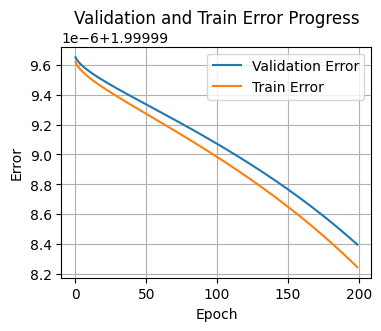

Train Perceptron error: 20, Test PE: 20
Train MAE error: 0.9999999182373337, Test MAE: 0.9999999528351615
Train MSE error: 1.999998244123247, Test MSE: 1.99999837742805


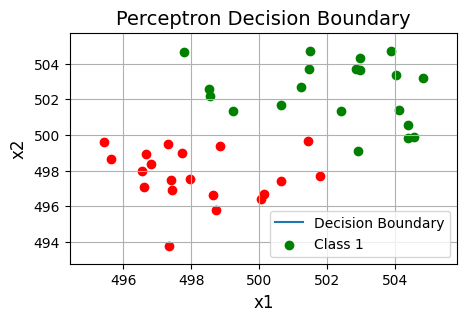

,Input,Predicted,True
0,"[498.5072717037158, 502.55835546726917]",[0.9999995797475152],1.0
1,"[504.0145407926594, 503.35730013198133]",[0.9999992856584627],1.0
2,"[504.3854188174532, 499.82065238077416]",[0.9999987300966698],1.0
3,"[500.64789099468214, 501.679817566812]",[0.9999993824472185],1.0
4,"[504.0993940230951, 501.3805209317769]",[0.9999990288556684],1.0
5,"[499.2383771598388, 501.3649525294433]",[0.999999451833864],1.0
6,"[502.40607833134186, 501.3327193478532]",[0.9999991991879722],1.0
7,"[497.7924515736284, 504.68013048988416]",[0.999999719231164],1.0
8,"[502.9163893252042, 499.11467338600744]",[0.9999988129104597],1.0
9,"[504.56302132735885, 499.89578571177276]",[0.9999987177333404],1.0


In [164]:
def example_random_clusters():
  return example_shifted_clusters()
  # return example_normalized_clusters()

# Data and parameters:
np.random.seed(642)
inputs, true_outputs = example_random_clusters()
test_inputs, test_true_outputs = example_random_clusters()
validation_data = example_random_clusters()
data_description = "Clusters"

activation = 'tanh'
print_progress = True
learning_rate = 0.0005
init_method = 'random'
adaptive_learning_rate = True #False
min_error = 0.0001
epochs = 200
variant = "iterative" #"batch" #"iterative"
max_validation_steps = 5 #  early stopping

# Train the neuron:
perceptron = Perceptron(inputs.shape[1], activation, init_method)
if variant == 'iterative':
    [training_errors, validation_errors] = perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)
else:
    [training_errors, validation_errors] = perceptron.gradient_descent_batch(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)


# Print summary:
print(perceptron)
plot_error_progress(training_errors, validation_errors)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
test_outputs = perceptron.forward(test_inputs)
print(f"Train Perceptron error: {perceptron_error(true_outputs, real_outputs)}, Test PE: {perceptron_error(test_true_outputs, test_outputs)}")
print(f"Train MAE error: {MAE_error(true_outputs, real_outputs)}, Test MAE: {MAE_error(test_true_outputs, test_outputs)}")
print(f"Train MSE error: {MSE_error(true_outputs, real_outputs)}, Test MSE: {MSE_error(test_true_outputs, test_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df


- normalize the data and run the experiment again:

Gradient Descent iterative:
Epoch: 0, Training MSE: 0.2568, Validation MSE: 0.4286 Val steps: 0 Weights: [[0.65662707 0.9303197 ]] Bias: -0.12984552967000096 Learning rate: 0.1000
Epoch: 1, Training MSE: 0.1815, Validation MSE: 0.3804 Val steps: 0 Weights: [[0.86773653 1.27346747]] Bias: -0.1542570797397904 Learning rate: 0.0707
Epoch: 2, Training MSE: 0.1586, Validation MSE: 0.3753 Val steps: 0 Weights: [[0.92196469 1.44905503]] Bias: -0.2124073770585808 Learning rate: 0.0577
Epoch: 3, Training MSE: 0.1450, Validation MSE: 0.3698 Val steps: 0 Weights: [[0.95731165 1.57143896]] Bias: -0.20203452346311182 Learning rate: 0.0500
Epoch: 4, Training MSE: 0.1363, Validation MSE: 0.3675 Val steps: 0 Weights: [[0.98583237 1.66232518]] Bias: -0.20965625482448946 Learning rate: 0.0447
Epoch: 5, Training MSE: 0.1299, Validation MSE: 0.3679 Val steps: 1 Weights: [[1.00238908 1.73692368]] Bias: -0.23177344434500752 Learning rate: 0.0408
Epoch: 6, Training MSE: 0.1251, Validation MSE: 0.3680 Val ste

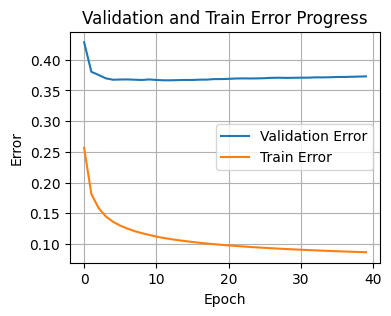

Train Perceptron error: 3, Test PE: 11
Train MAE error: 0.1770311857723179, Test MAE: 0.37490527244386873
Train MSE error: 0.08675288281647767, Test MSE: 0.4610599665791589


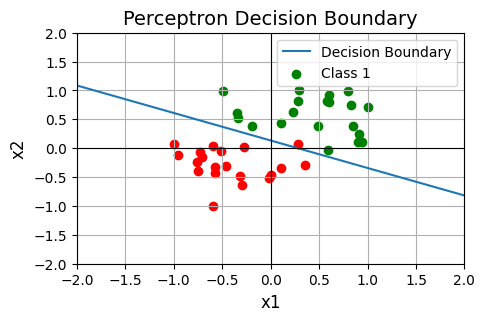

,Input,Predicted,True
0,"[-0.343649568119454, 0.6019865918489369]",[0.644858260767074],1.0
1,"[0.8270957930544727, 0.7478150561703909]",[0.9875991171126635],1.0
2,"[0.9059377236150226, 0.10228360301240436]",[0.7644154865727887],1.0
3,"[0.11140720583945352, 0.44163026364438207]",[0.7203734954665629],1.0
4,"[0.8451340483691963, 0.3870007372309723]",[0.9290076362491319],1.0
5,"[-0.1882298296862308, 0.3841590933668566]",[0.38348391884420874],1.0
6,"[0.48516589371645136, 0.3782756879458109]",[0.8328091946707098],1.0
7,"[-0.49560734208289836, 0.9892664709817871]",[0.9153900130049183],1.0
8,"[0.5936487405088506, -0.026576175639631994]",[0.2981060634290337],1.0
9,"[0.943692790826518, 0.11599741670040009]",[0.7956335606310091],1.0


In [165]:
def example_random_clusters():
  #return example_shifted_clusters() # comment this row to normalize the data
  return example_normalized_clusters()

# Data and parameters:
np.random.seed(642)
inputs, true_outputs = example_random_clusters()
test_inputs, test_true_outputs = example_random_clusters()
validation_data = example_random_clusters()
data_description = "Clusters"

activation = 'tanh'
print_progress = True
learning_rate = 0.1
init_method = 'random'
adaptive_learning_rate = True #False
min_error = 0.0001
epochs = 200
variant = "iterative" #"batch" #"iterative"
max_validation_steps = 5 #  early stopping

# Train the neuron:
perceptron = Perceptron(inputs.shape[1], activation, init_method)
if variant == 'iterative':
    [training_errors, validation_errors] = perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)
else:
    [training_errors, validation_errors] = perceptron.gradient_descent_batch(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)


# Print summary:
print(perceptron)
plot_error_progress(training_errors, validation_errors)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
test_outputs = perceptron.forward(test_inputs)
print(f"Train Perceptron error: {perceptron_error(true_outputs, real_outputs)}, Test PE: {perceptron_error(test_true_outputs, test_outputs)}")
print(f"Train MAE error: {MAE_error(true_outputs, real_outputs)}, Test MAE: {MAE_error(test_true_outputs, test_outputs)}")
print(f"Train MSE error: {MSE_error(true_outputs, real_outputs)}, Test MSE: {MSE_error(test_true_outputs, test_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df


## Example 6  - Outliers

In [166]:
def example_outliers():
    # data with outliers
    inputs = np.array([
        [-0.5, -0.5],
        [ 0.3, -0.5],
        [ -40,   50], # outlier
        [ -0.8, 1],
        [ -0.1, 1.0]
    ])

    true_outputs = np.array([1, 1, -1, -1, 1])
    return inputs, true_outputs

def normalize_data(data):
    """Normalizes data to the range [-1, 1]."""
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)

    # Avoid division by zero if min and max are the same
    max_vals = np.where(max_vals == min_vals, max_vals + 1e-6, max_vals)

    normalized_data = 2 * (data - min_vals) / (max_vals - min_vals) - 1
    return normalized_data

def example_normalized_outliers():
    inputs, true_outputs = example_outliers()
    return normalize_data(inputs), true_outputs

def normalize_data_std(data):
    """Normalizes data using standard deviation."""
    mean_vals = np.mean(data, axis=0)
    std_vals = np.std(data, axis=0)

    # Avoid division by zero if standard deviation is zero
    std_vals = np.where(std_vals == 0, 1e-6, std_vals)  # Add a small value to avoid division by zero

    normalized_data = (data - mean_vals) / std_vals
    return normalized_data

def example_std_normalized_outliers():
    inputs, true_outputs = example_outliers()
    return normalize_data_std(inputs), true_outputs

- Set the parameters, run the experiment and observe the results:
- Observe, that the percepron is able to learn the task

Gradient Descent iterative:
Epoch: 0, MSE: 0.1922 Weights: [[ 0.93845042 -1.11668625]] Bias: 1.446899587907085 Learning rate: 0.8000
Epoch: 1, MSE: 0.5720 Weights: [[ 1.50026526 -1.39125543]] Bias: 0.7735075060666863 Learning rate: 0.5657
Epoch: 2, MSE: 0.1858 Weights: [[ 1.3688815  -0.85792726]] Bias: 1.866101022782167 Learning rate: 0.4619
Epoch: 3, MSE: 0.2049 Weights: [[ 1.77489325 -1.31627067]] Bias: 1.5045010462118338 Learning rate: 0.4000
Epoch: 4, MSE: 0.0966 Weights: [[ 1.89409772 -1.13680952]] Bias: 1.7164525488703988 Learning rate: 0.3578
Epoch: 5, MSE: 0.0768 Weights: [[ 1.89847125 -0.95536516]] Bias: 1.932471597568355 Learning rate: 0.3266
Epoch: 6, MSE: 0.0695 Weights: [[ 1.98960964 -0.955711  ]] Bias: 1.9699226220238877 Learning rate: 0.3024
Epoch: 7, MSE: 0.0612 Weights: [[ 2.11052445 -1.07044981]] Bias: 1.9086906237339076 Learning rate: 0.2828
Epoch: 8, MSE: 0.0571 Weights: [[ 2.16666488 -1.07387326]] Bias: 1.9452271392870513 Learning rate: 0.2667
Epoch: 9, MSE: 0.0530

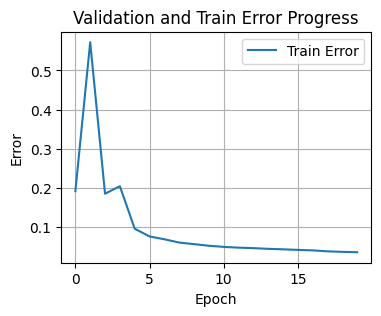

Perceptron error: 0
MAE error: 0.1372623972612457
MSE error: 0.036555735293740343


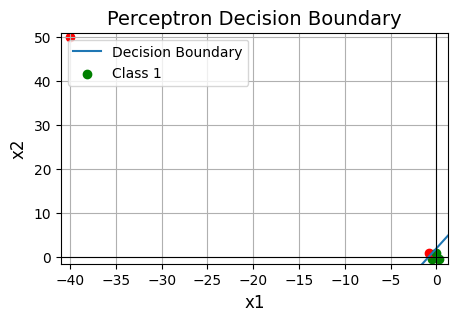

,Input,Predicted,True
0,"[-0.5, -0.5]",[0.9045625729076306],1
1,"[0.3, -0.5]",[0.9981937904753418],1
2,"[-40.0, 50.0]",[-1.0],-1
3,"[-0.8, 1.0]",[-0.7145858932215945],-1
4,"[-0.1, 1.0]",[0.6963457570892045],1


In [167]:
# Data and parameters:
inputs, true_outputs = example_outliers()
data_description = "Out"

print_progress = True
activation = 'tanh'
learning_rate = 0.8
init_method = 'random'
adaptive_learning_rate = True
min_error = 0.0001
epochs = 20

# Train the linear neuron:
perceptron = Perceptron(inputs.shape[1], activation, init_method)
# perceptron.set_weights(np.array([10000, 10000]), 10000) # set weights to large values
training_errors, validation_errors = perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress=print_progress)
# Print summary:
print(perceptron)
plot_error_progress(training_errors, validation_errors)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
error = perceptron_error(true_outputs, real_outputs)
print(f"Perceptron error: {error}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df


- Run the same example with normalization
- In this case, blind normalization leads to worse results.

Gradient Descent iterative:
Epoch: 0, MSE: 0.7583 Weights: [[ 1.86135538 -1.97156009]] Bias: -1.8232758708446517 Learning rate: 2.0000
Epoch: 1, MSE: 0.7533 Weights: [[ 1.59536584 -1.70720732]] Bias: -1.3850701348101062 Learning rate: 1.4142
Epoch: 2, MSE: 1.9653 Weights: [[ 1.4006528  -1.51341052]] Bias: -3.9779303403212625 Learning rate: 1.1547
Epoch: 3, MSE: 0.7987 Weights: [[ 3.22724031 -3.36806756]] Bias: -2.6796474581557574 Learning rate: 1.0000
Epoch: 4, MSE: 0.7323 Weights: [[ 3.2209291  -3.36178848]] Bias: -4.674814866066906 Learning rate: 0.8944
Epoch: 5, MSE: 0.7918 Weights: [[ 4.02796932 -4.12861387]] Bias: -5.061713203533649 Learning rate: 0.8165
Epoch: 6, MSE: 0.7010 Weights: [[ 4.06815038 -4.16703736]] Bias: -6.4439369824168615 Learning rate: 0.7559
Epoch: 7, MSE: 0.7741 Weights: [[ 4.65100099 -4.78574953]] Bias: -6.85329158090363 Learning rate: 0.7071
Epoch: 8, MSE: 0.5033 Weights: [[ 4.57306791 -4.708205  ]] Bias: -8.210259616242535 Learning rate: 0.6667
Epoch: 9, MSE:

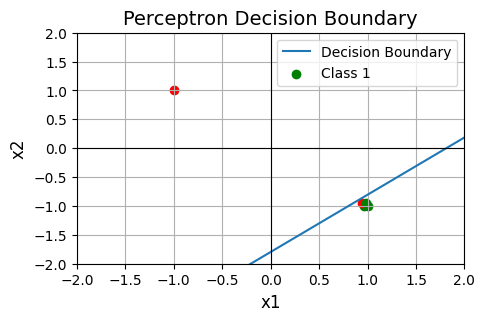

,Input,Predicted,True
0,"[0.9602977667493797, -1.0]",[0.826349903130652],1
1,"[1.0, -1.0]",[0.9004745052924855],1
2,"[-1.0, 1.0]",[-1.0],-1
3,"[0.9454094292803974, -0.9405940594059405]",[0.5473504406158413],-1
4,"[0.9801488833746899, -0.9405940594059405]",[0.7041684225931497],1


In [168]:
# Data and parameters:
inputs, true_outputs = example_normalized_outliers()
#inputs, true_outputs = example_std_normalized_outliers()
data_description = "Out"

print_progress = True
activation = 'tanh'
learning_rate = 2
init_method = 'random'
adaptive_learning_rate = True
min_error = 0.0001
epochs = 50

# Train the linear neuron:
perceptron = Perceptron(inputs.shape[1], activation, init_method)
# perceptron.set_weights(np.array([10000, 10000]), 10000) # set weights to large values
perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress=print_progress)
# Print summary:
print(perceptron)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
error = perceptron_error(true_outputs, real_outputs)
print(f"Perceptron error: {error}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df